In [1]:
# 导入必要的库
import decoupler as dc
import pertpy as pt
import scanpy as sc
import warnings

# 忽略警告信息
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_h5ad("results/anndata_annotation_harmony_celltypist.h5ad")
adata=adata.raw.to_adata()

In [3]:

# 将原始计数存储在一个层中，因为大多数DGE模型需要原始计数
adata.layers["counts"] = adata.X.copy()
adata


AnnData object with n_obs × n_vars = 64354 × 17065
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine

In [ ]:
ANNO_COL = "celltypist"
SAMPEL_COL = "patients_organ"
GROUPs_COL = "group"


CTROL = "CNL"
STIM = "CCL"
DIR = "figures"

In [5]:
# 创建伪批量样本
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    adata,
    target_col=SAMPEL_COL,
    groups_col=ANNO_COL,
    layer_key="counts",
    mode="sum",
    min_cells=10,
    min_counts=1000,
)

In [6]:

# 对伪批量样本进行预处理和PCA分析
pdata.layers["counts"] = pdata.X.copy()
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)



In [7]:
# 返回原始计数到X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

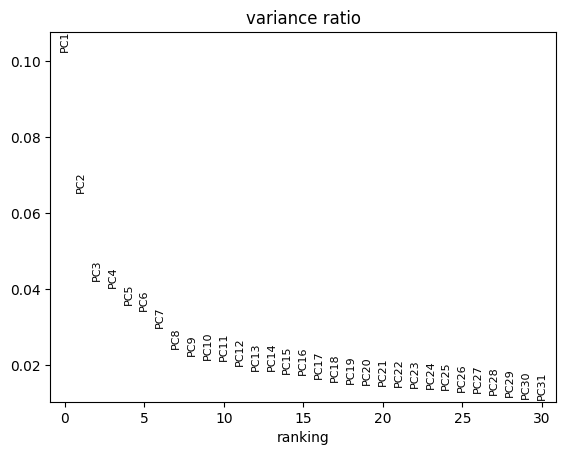

In [8]:
sc.pl.pca_variance_ratio(pdata)

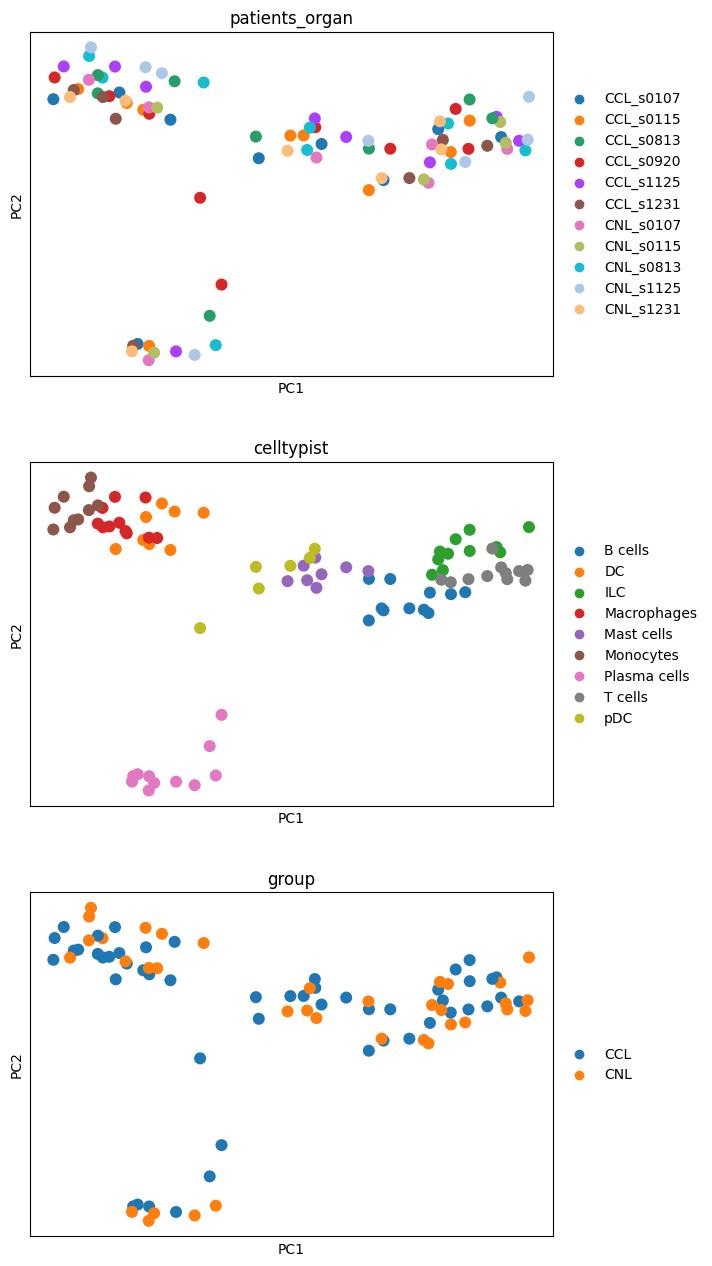

In [9]:
sc.pl.pca(pdata, color=[SAMPEL_COL, ANNO_COL, GROUPs_COL], ncols=1, size=300)

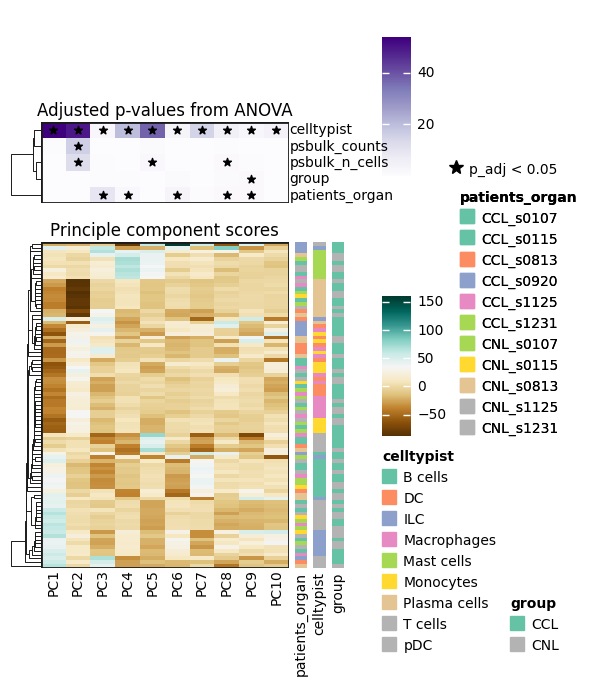

In [ ]:
# 方差分析
"""
为了更好地了解 PC 与样本元数据的关联，我们对每个 PC 执行方差分析，看看它们是否与样本的任何技术或生物学注释有显著关联
"""
dc.get_metadata_associations(
    pdata,
    obs_keys=[
        SAMPEL_COL,
        ANNO_COL,
        GROUPs_COL,
        "psbulk_n_cells",
        "psbulk_counts",
    ],
    obsm_key="X_pca",
    uns_key="pca_anova",
    inplace=True,
)
dc.plot_associations(
    pdata,
    uns_key="pca_anova",
    obsm_key="X_pca",
    stat_col="p_adj",
    obs_annotation_cols=[
        SAMPEL_COL,
        ANNO_COL,
        GROUPs_COL,
    ],
    titles=["Principle component scores", "Adjusted p-values from ANOVA"],
    save=f"{DIR}-ANOVA.pdf",
    return_fig=True,
)

In [11]:

# 使用edgeR进行差异基因表达分析
edgr = pt.tl.EdgeR(
    pdata,
    design=f"~{GROUPs_COL}",  #应该加其他协变量
    # contrast=("group", "CCL", "CNL")
    )
edgr.fit()



In [12]:
# 计算对比以确定不同处理之间的差异基因
res_df = edgr.test_contrasts(
    edgr.contrast(column=GROUPs_COL, baseline=CTROL, group_to_compare=STIM)
)
res_df

,variable,log_fc,logCPM,F,p_value,adj_p_value,contrast
0,PGLYRP1,-3.716448,0.846107,7.032089e+01,5.827582e-13,9.944769e-09,None
1,DNAJA4,4.009812,7.223867,5.880192e+01,1.797636e-11,1.533833e-07,None
2,HBB,-3.439435,1.350982,5.518076e+01,5.590070e-11,2.613578e-07,None
3,SPP1,8.096552,7.980275,5.489245e+01,6.126172e-11,2.613578e-07,None
4,FN1,6.308895,5.175040,5.340982e+01,9.840529e-11,3.358573e-07,None
...,...,...,...,...,...,...,...
17060,PXK,-0.000109,5.183906,2.800366e-07,9.995789e-01,9.998133e-01,None
17061,DNM1L,-0.000172,4.997342,1.726750e-07,9.996693e-01,9.998273e-01,None
17062,RAB18,0.000018,4.968223,1.327590e-07,9.997101e-01,9.998273e-01,None
17063,GJA3,0.012673,0.612937,3.735195e-08,9.998462e-01,9.999048e-01,None


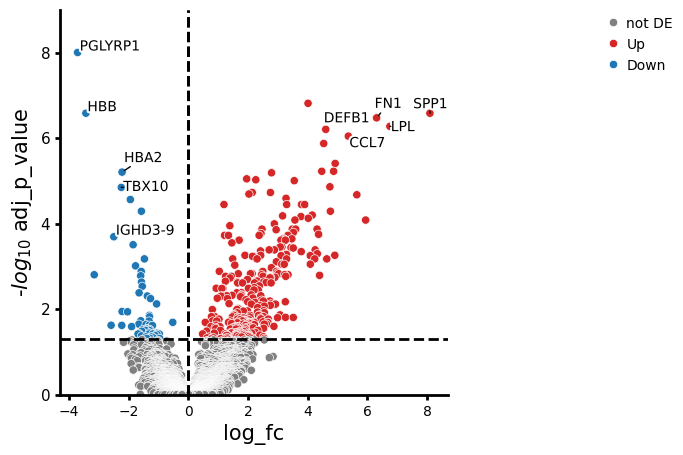

In [ ]:
edgr.plot_volcano(
    res_df,
    # pvalue_col="p_value",
    log2fc_thresh=0,
    save=f"{DIR}/伪批量差异分析.pdf",
)

<Figure size 1000x800 with 0 Axes>

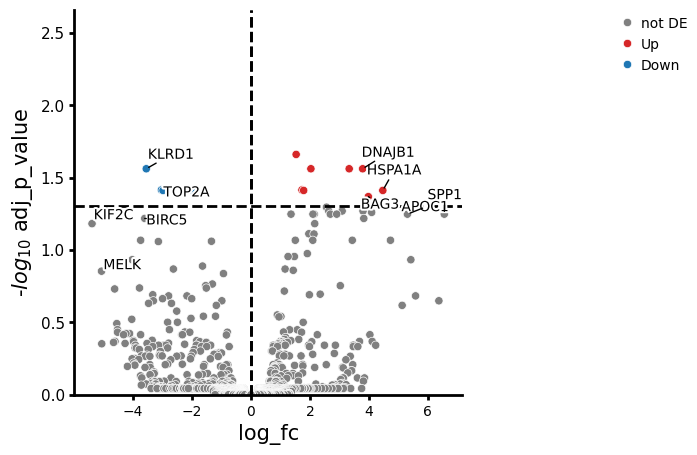

<Figure size 1000x800 with 0 Axes>

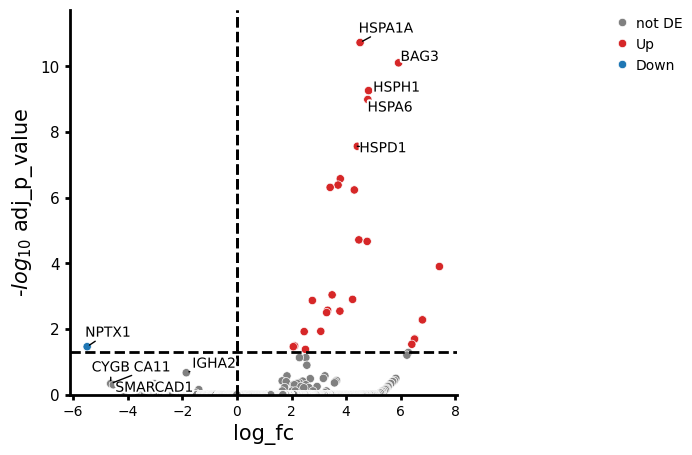

<Figure size 1000x800 with 0 Axes>

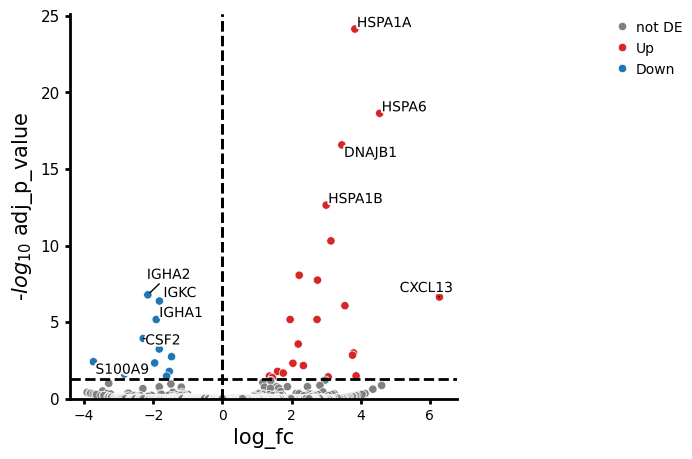

<Figure size 1000x800 with 0 Axes>

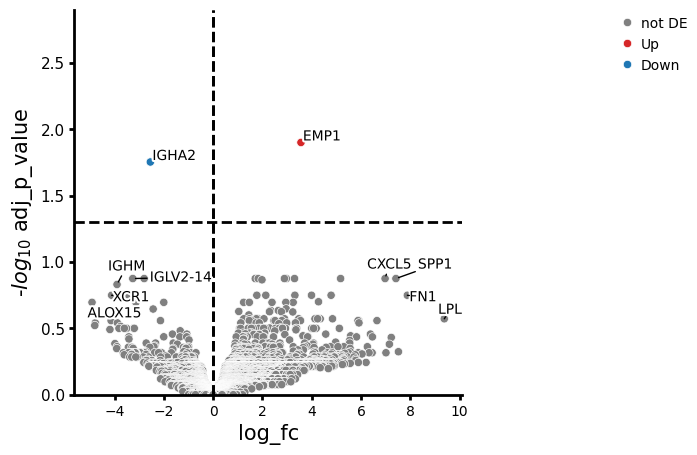

<Figure size 1000x800 with 0 Axes>

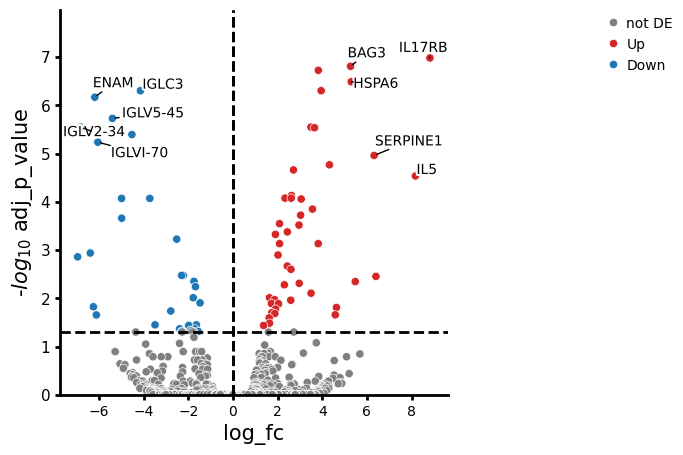

<Figure size 1000x800 with 0 Axes>

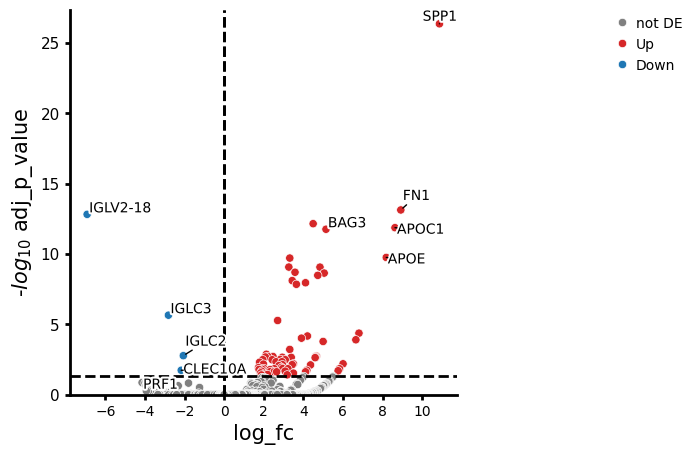

<Figure size 1000x800 with 0 Axes>

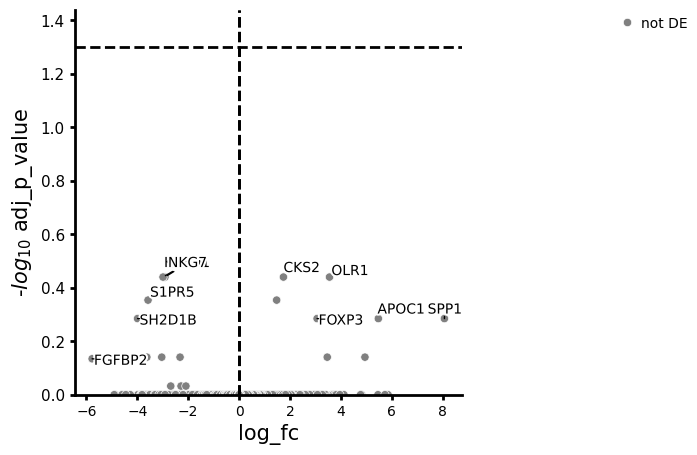

In [ ]:
import os


def analyze_and_plot(pdata, anno_col, groups_col, control, stim, output_dir="output"):
    """
    Analyze differential expression and plot volcano plots for each cell type.

    Args:
        pdata: The input data, expected to be an AnnData object.
        anno_col: The column in pdata.obs containing cell type annotations.
        groups_col: The column in pdata.obs used for grouping in the design formula.
        control: The baseline group for the contrast.
        stim: The group to compare against the baseline.
        output_dir: Directory to save output files.
    """
    os.makedirs(output_dir, exist_ok=True)

    for cell in pdata.obs[anno_col].unique():
        # Filter data for the specific cell type
        cell_data = pdata[pdata.obs[anno_col] == cell]

        # Perform differential expression analysis using EdgeR
        edgr = pt.tl.EdgeR(
            cell_data,
            design=f"~{groups_col}",
        )
        edgr.fit()

        # Test contrasts
        res_df = edgr.test_contrasts(
            edgr.contrast(column=groups_col, baseline=control, group_to_compare=stim)
        )

        # Save differential expression results
        table_filename = os.path.join(output_dir, f"{cell}_differential_expression.csv")
        res_df.to_csv(table_filename, index=False)

        # Plot volcano plot and annotate with cell type
        plot_filename = os.path.join(output_dir, f"{cell}_volcano_plot.pdf")
        edgr.plot_volcano(
            res_df,
            log2fc_thresh=0,
            save=plot_filename,
        )

# Example usage:
analyze_and_plot(pdata, ANNO_COL, GROUPs_COL, CTROL, STIM, output_dir=DIR)

In [13]:
# 使用PyDESeq2进行差异基因表达分析
pds2 = pt.tl.PyDESeq2(adata=pdata, design="~group")
pds2.fit()

# 对比不同的疗效组
res_df = pds2.test_contrasts([{GROUPs_COL}, CTROL, STIM])
res_df

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 6.37 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 7.08 seconds.

Fitting LFCs...
... done in 7.07 seconds.

Replacing 456 outlier genes.

Fitting dispersions...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 0.43 seconds.

Fitting LFCs...
... done in 0.39 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: group CNL vs CCL
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG    10.348271        0.075283  0.234188  0.321465  0.747858  0.943325
A1CF     0.070769        0.041846  0.900313  0.046480  0.962928       NaN
A2M      3.113628       -0.508346  0.649286 -0.782930  0.433668  0.845272
A2ML1    0.020504       -0.117569  1.387654 -0.084725  0.932480       NaN
A4GALT   1.540134        0.171985  0.659443  0.260804  0.794244  0.953775
...           ...             ...       ...       ...       ...       ...
ZXDC     5.884058        0.339500  0.163491  2.076575  0.037841  0.424642
ZYG11A   0.322645       -0.438436  0.813101 -0.539214  0.589739       NaN
ZYG11B   8.089471        0.255085  0.164669  1.549077  0.121363  0.631544
ZYX     99.228897       -0.131314  0.248216 -0.529032  0.596783  0.899411
ZZEF1   11.616788        0.073408  0.161041  0.455833  0.648510  0.916426

[17065 rows x 6 columns]


... done in 6.38 seconds.



,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,SMS,22.516344,-7.263696e-01,0.041538,-17.486931,1.802049e-68,2.002077e-64,None
1,DNAJA4,75.315689,-4.320497e+00,0.453300,-9.531213,1.554554e-21,8.635547e-18,None
2,ZFAND2A,118.058327,-3.139903e+00,0.394520,-7.958795,1.737229e-15,6.433538e-12,None
3,HSPA6,395.817627,-4.086298e+00,0.520381,-7.852519,4.077643e-15,1.132565e-11,None
4,HSPH1,451.390747,-3.012240e+00,0.387157,-7.780404,7.229323e-15,1.606356e-11,None
...,...,...,...,...,...,...,...,...
17060,IGHV1OR16-1,0.173917,2.037754e-04,1.458949,0.000140,9.998886e-01,NaN,None
17061,GOLGA8R,0.169877,1.504623e-04,1.382743,0.000109,9.999132e-01,NaN,None
17062,SP100,58.869625,1.313972e-05,0.158503,0.000083,9.999339e-01,9.999987e-01,None
17063,SH2B1,5.269578,-1.640280e-05,0.212444,-0.000077,9.999384e-01,9.999987e-01,None


NaNs encountered, dropping rows with NaNs


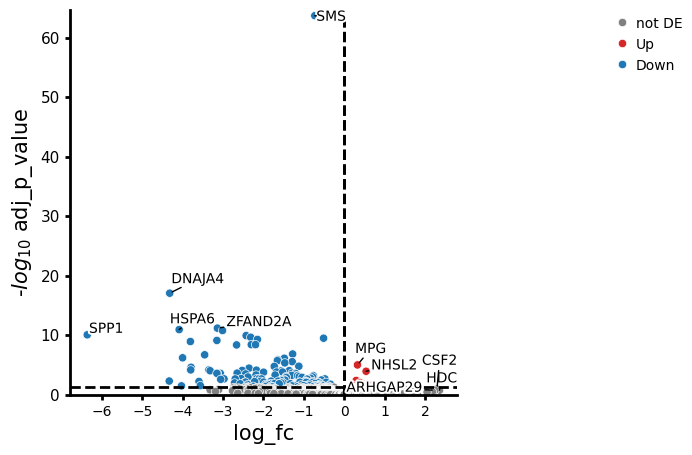

In [ ]:
edgr.plot_volcano(
    res_df,
    # pvalue_col="p_value",
    log2fc_thresh=0,
    save=f"{DIR}/伪批量差异分析.pdf",
)